In [1]:
#DATA MANIPULATION
import pandas as pd
import numpy as np

#EMBEDDING AND PREPROCESSING
from gensim.models import KeyedVectors
import re
import nltk
import gensim
import multiprocessing
import spacy
from sklearn.preprocessing import LabelBinarizer

#TIME CONTROLS
import time

#PLOT
import matplotlib.pyplot as plt
plt.style.use("ggplot")
get_ipython().run_line_magic('matplotlib', 'inline')

#TENSORFLOW AND KERAS
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional, GlobalAveragePooling1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer

import random
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#tf.debugging.set_log_device_placement(True)

unable to import 'smart_open.gcs', disabling that module


Num GPUs Available:  1


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def load_embedding(filename, encoding='utf-8'):
    # load embedding into memory, skip first line
    file = open(filename,'r',encoding=encoding)
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        try:
            embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
        except:
            pass
    return embedding


def get_weight_matrix(embedding, vocab, seq_len):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, seq_len))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = embedding.get(word)
    return weight_matrix

def cleaning(doc):
    txt = [token.text for token in doc]
    if len(txt) > 2:        
        return re.sub(' +', ' ', ' '.join(txt)).strip()

def preprocess_string(string, word_vectors):
    unk_string = '<unk>'
    counter = 0
    string = re.sub('[().\\/\-_\+":“0-9]', ' ', str(string)).lower()
    for word in string.split():
        try:
            word_vectors[word]
            string_to_attatch = word
        except:
            string_to_attatch = unk_string
        
        if counter:
            string = string +' '+ string_to_attatch
        else:
            string = string_to_attatch
            counter = 1
    
    return string

def pad_sequence(string, tokenizer):
    encoded_string = tokenizer.texts_to_sequences(string)
    padded_enconded = pad_sequences(encoded_string, maxlen=max_length, padding='post')
    return padded_enconded

def preprocess_to_predict(string, word_vectors, tokenizer):
    string = preprocess_string(string, word_vectors)    
    padded_sequence = pad_sequence(string, tokenizer)
    
    return padded_sequence

In [4]:
categories = ['neg, pos']

In [5]:
df = pd.read_csv(
    'imdb-reviews-pt-br.csv',              
    index_col=0, 
    sep=',',
    encoding='utf-8', 
    dtype=str, 
    quotechar='"').dropna()
df.head()

,text_en,text_pt,sentiment
id,,,
1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


In [6]:
raw_embedding = load_embedding('glove_s50.txt')
txt = [preprocess_string(doc, raw_embedding) for doc in df['text_pt']]

In [7]:
df_clean = pd.DataFrame({'clean': txt})

In [8]:
df_clean.shape

(49459, 1)

In [9]:
df_clean.tail()

,clean
49454,como a média de votos era muito <unk> e o fato...
49455,o enredo teve algumas reviravoltas infelizes e...
49456,estou espantado com a forma como este filme e ...
49457,a christmas together realmente veio antes do m...
49458,o drama romântico da classe trabalhadora do di...


In [10]:
x_input = df_clean['clean'].values.tolist()
labels = df['sentiment'].values.tolist()

In [11]:
temp_df = pd.DataFrame(list(zip(x_input,labels)), columns=['clean','Category']).dropna()
len(temp_df)

49459

In [12]:
temp_df.head()

,clean,Category
0,mais uma <unk> o sr costner arrumou um filme p...,neg
1,este é um exemplo do motivo pelo qual a maiori...,neg
2,primeiro de tudo eu odeio esses raps <unk> que...,neg
3,nem mesmo os beatles puderam escrever músicas ...,neg
4,filmes de fotos de latão não é uma palavra apr...,neg


In [13]:
temp_df = temp_df.sample(frac=1)
temp_df = temp_df.dropna()

In [14]:
temp_df['Cat_Num'] = np.where(temp_df['Category']=='neg', 0, 1)

In [15]:
temp_df.tail(10)

,clean,Category,Cat_Num
23891,aqui está o que você tem que lembrar sobre est...,pos,1
29374,eu tenho esse filme porque eu trabalhei em uma...,neg,0
35200,eu vi esse filme lá atrás quando foi lançado f...,neg,0
32603,este filme foi fantástico grande filme todo as...,neg,0
34596,"com um título como ataque dos tomates <unk> , ...",neg,0
43685,este filme é rico em ação e gore o enredo é fo...,pos,1
2731,estrutura básica de uma história <unk> <unk> e...,neg,0
37968,eu recomendo este filme para todos não só para...,pos,1
27660,este filme foi alugado por um amigo sua escolh...,neg,0
4012,imagine se você pegasse o mito de <unk> mistur...,neg,0


In [16]:
x_input = temp_df['clean'].values.tolist()
labels = temp_df['Category'].values.tolist()

In [17]:
t = Tokenizer()
t.fit_on_texts(x_input)
vocab_size = len(t.word_index) + 1

In [18]:
embedding_vectors = get_weight_matrix(raw_embedding, t.word_index, seq_len=50)

In [19]:
encoded_docs = t.texts_to_sequences(x_input)

In [20]:
max_length = 200
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [21]:
padded_docs.shape

(49459, 200)

In [22]:
y = temp_df['Cat_Num'].values
y.shape

(49459,)

In [23]:
e = Embedding(vocab_size, 50, weights=[embedding_vectors], mask_zero=False, input_length=max_length, trainable=False)
#e = Embedding(vocab_size, 50, weights=[embedding_vectors], mask_zero=True, input_length=max_length, trainable=False)

In [24]:
'''
#ARCHTECTURE #1
try:
    del model
except:
    pass
model = Sequential()
model.add(e)
model.add(GlobalAveragePooling1D())
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=0.00001),
              metrics=['accuracy'])
'''

"\n#ARCHTECTURE #1\ntry:\n    del model\nexcept:\n    pass\nmodel = Sequential()\nmodel.add(e)\nmodel.add(GlobalAveragePooling1D())\nmodel.add(Flatten())\nmodel.add(Dense(16, activation='relu'))\nmodel.add(Dense(32, activation='relu'))\nmodel.add(Dense(2, activation='softmax'))\n\n\nmodel.compile(loss='sparse_categorical_crossentropy',\n              optimizer=Adam(lr=0.00001),\n              metrics=['accuracy'])\n"

In [25]:
'''
#ARCHTECTURE #2
try:
    del model
except:
    pass
model = Sequential()
model.add(e)
model.add(LSTM(200, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(16, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=0.00001),
              metrics=['accuracy'])
'''

"\n#ARCHTECTURE #2\ntry:\n    del model\nexcept:\n    pass\nmodel = Sequential()\nmodel.add(e)\nmodel.add(LSTM(200, return_sequences=True))\nmodel.add(LSTM(100))\nmodel.add(Dense(16, activation='relu'))\nmodel.add(Dense(32, activation='relu'))\nmodel.add(Dense(2, activation='softmax'))\n\n\nmodel.compile(loss='sparse_categorical_crossentropy',\n              optimizer=Adam(lr=0.00001),\n              metrics=['accuracy'])\n"

In [26]:
#ARCHTECTURE #3
try:
    del model
except:
    pass
model = tf.keras.Sequential([
    e,
    Bidirectional(LSTM(32,  return_sequences=True)),
    Bidirectional(LSTM(16)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1)

])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 50)           4734250   
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 64)           21248     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 4,768,043
Trainable params: 33,793
Non-trainable params: 4,734,250
_________________________________________

In [28]:
import gc
gc.collect()

0

In [29]:
#with tf.device('/device:GPU:0'):

hist = model.fit([padded_docs], 
                 y, 
                 validation_split=0.2,
                 epochs=20,
                 batch_size=64, 
                 shuffle=True,
                 verbose=2
)

Train on 39567 samples, validate on 9892 samples
Epoch 1/20
39567/39567 - 48s - loss: 0.6820 - accuracy: 0.5168 - val_loss: 0.6897 - val_accuracy: 0.5118
Epoch 2/20
39567/39567 - 23s - loss: 0.6315 - accuracy: 0.6385 - val_loss: 0.5863 - val_accuracy: 0.7016
Epoch 3/20
39567/39567 - 22s - loss: 0.6301 - accuracy: 0.6348 - val_loss: 0.6628 - val_accuracy: 0.5291
Epoch 4/20
39567/39567 - 22s - loss: 0.6261 - accuracy: 0.6180 - val_loss: 0.5822 - val_accuracy: 0.6850
Epoch 5/20
39567/39567 - 22s - loss: 0.5747 - accuracy: 0.7035 - val_loss: 0.5553 - val_accuracy: 0.7285
Epoch 6/20
39567/39567 - 22s - loss: 0.5597 - accuracy: 0.7098 - val_loss: 0.5430 - val_accuracy: 0.7143
Epoch 7/20
39567/39567 - 22s - loss: 0.5455 - accuracy: 0.7157 - val_loss: 0.5324 - val_accuracy: 0.7406
Epoch 8/20
39567/39567 - 22s - loss: 0.5345 - accuracy: 0.7244 - val_loss: 0.5375 - val_accuracy: 0.7494
Epoch 9/20
39567/39567 - 23s - loss: 0.5215 - accuracy: 0.7336 - val_loss: 0.5100 - val_accuracy: 0.7496
Epoch 

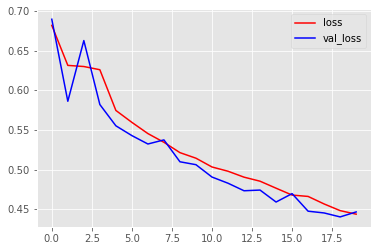

In [30]:
history = pd.DataFrame(hist.history)
#plt.figure(figsize=(12,12))

plt.plot(history["loss"], 'r',label='loss')
plt.plot(history["val_loss"], 'b', label='val_loss')
plt.legend()
plt.show()

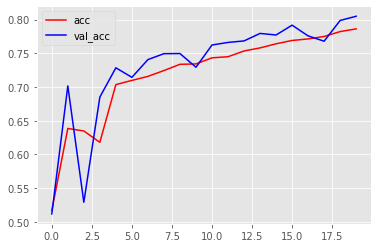

In [31]:
history = pd.DataFrame(hist.history)
#plt.figure(figsize=(12,12))

plt.plot(history["accuracy"], 'r',label='acc')
plt.plot(history["val_accuracy"], 'b', label='val_acc')
plt.legend()
plt.show()

In [39]:
#test_string = "Este foi o pior filme que eu tive o desprazer de assistir em toda a minha vida."
#test_string = "Péssimo. Odiei a atuação e foi simplesmente patético. Não sei porque as pessoas ainda insistem nesse tipo de filme"
#test_string = "Mais uma vez, o Sr. Costner arrumou um filme por muito mais tempo do que o necessário. Além das terríveis seqüências de resgate no mar, das quais há muito poucas, eu simplesmente não me importei com nenhum dos personagens. A maioria de nós tem fantasmas no armário, e o personagem Costers é realizado logo no início, e depois esquecido até muito mais tarde, quando eu não me importava. O personagem com o qual deveríamos nos importar é muito arrogante e superconfiante, Ashton Kutcher. O problema é que ele sai como um garoto que pensa que é melhor do que qualquer outra pessoa ao seu redor e não mostra sinais de um armário desordenado. Seu único obstáculo parece estar vencendo Costner. Finalmente, quando estamos bem além do meio do caminho, Costner nos conta sobre os fantasmas dos Kutchers. Somos informados de por que Kutcher é levado a ser o melhor sem pressentimentos ou presságios anteriores. Nenhuma mágica aqui, era tudo que eu podia fazer para não desligar uma hora."

#test_string = "O drama romântico da classe trabalhadora do diretor Martin Ritt é tão inacreditável quanto eles são, mas há momentos de prazer devido principalmente ao carisma das estrelas Jane Fonda e Robert De Niro, ambos ótimos. Ela é uma viúva que não pode seguir em frente, é analfabeta e é uma inventora de armários - provavelmente você pode adivinhar o resto. Adaptação do romance de Pat Barkers ""Union Street"" um título melhor! é tão descontraído que beirar sem graça, e a edição de filmes é uma bagunça, mas ainda é agradável; uma fantasia de colarinho azul em tons rosados. Não há aberturas para questões sérias, mesmo o ângulo do analfabetismo é apenas uma ferramenta de enredo para a história de amor que se segue e não há fogos de artifício reais, embora os personagens sejam intencionalmente um pouco incolores e as derivações reduzidas a um nível interessante. O final é puro fluff - e os cínicos acharão difícil de engolir - embora esses dois personagens mereçam um final feliz e a foto não seria realmente satisfatória de outra maneira. a partir de"
#test_string = 'Eu vi pela primeira vez a Idade do Gelo nos Cinemas Subiaco quando saiu, de volta em 02. Eu tinha apenas 13 anos na época, mas mesmo assim eu gostei. Ele tinha algum tipo de calor. Nós o tivemos em vídeo por vários anos e não importa quantas vezes você assiste, nunca fica chato. Isto é devido ao elemento que o torna diferente de todas as outras animações em 3D feitas na época - os personagens não têm um lar particular que eles deixam. Eles são nômades, e isso é realmente refrescante e edificante para assistir.Além disso, cada personagem individual na superfície, parece estar apenas colocando-se uns com os outros, mas eles são realmente todos bons amigos. Além disso, todos os personagens têm seus próprios encantos, até os bandidos. Sid, o preguiçoso, é encantador em sua forma irritante, excessivamente afetuosa e ingênua. Manny é adorável em seu personagem deprimido e recluso, e assim por diante. Outro grande ponto sobre o filme é a beleza da animação. Todos os ambientes e personagens foram modelados originalmente pelo barro, dando ao filme uma vantagem artística. Outro aspecto que aumenta a sensação do filme, é que gênero significa muito pouco. Quase não há personagens femininos, mas você realmente não percebe isso até depois de assisti-lo algumas vezes e mesmo assim ele tem pouco efeito sobre a maneira como você vê o filme. Devido a isso, há também nenhuma menção de uma família nuclear que seria realmente patética em um cenário como a idade do gelo.Em tudo, Ice Age é um grande filme e é a prova de quanto esforço foi colocado em animações em 3D antes de Shrek 2 e os Incríveis saíram.'
test_string = "Este é simplesmente o melhor filme que eu pude ter o prazer de asssitir em toda minha vida! Simplesmente incrível! Eu adorei a atuação do Jim Carrey e casaria com ele"

padded_sequence_to_predict = preprocess_to_predict(string=test_string,
                                                word_vectors=raw_embedding,
                                                tokenizer=t
                                                )
prediction = model.predict(padded_sequence_to_predict)[0] #predict always returns a list
#batch_pred = model.predict(padded_docs)
#predicted_label = prediction.argmax()
prediction_score = prediction[0]


#print(f'Predicted: {predicted_label}')
print(f'Predicted: {prediction_score}')

Predicted: -0.2980053126811981


In [48]:
test_string = "Ele é um é ele"

padded_sequence_to_predict = preprocess_to_predict(string=test_string,
                                                word_vectors=raw_embedding,
                                                tokenizer=t
                                                )

In [49]:
padded_sequence_to_predict.shape

(14, 200)

In [54]:
padded_docs[1].shape

(200,)

In [56]:
padded_sequence_to_predict[0].shape

(200,)

In [35]:
counter_pos = 0
for pred in batch_pred:
    if pred > 0.5:
        counter_pos+=1

print(counter_pos)
print(len(batch_pred))
print(counter_pos/len(batch_pred))

24943
49459
0.5043167067672213


In [ ]:
def plot_prediction_array(string_to_predict, predictions_array, true_label):
    plt.grid(False)
    plt.xticks([])
    #plt.yticks([])
    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(string_to_predict[:100], color=color)    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [ ]:
plot_prediction_array(test_string,prediction,1)

In [ ]:
prediction